In [12]:
#Deeplab/saved_models/india_sam_dino_250_samples_0.8924413878050058.pth
# Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth
%cd /teamspace/studios/this_studio/Deeplab/

/teamspace/studios/this_studio/Deeplab


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from torch.utils.data import dataset
from tqdm import tqdm
import network
import utils
import os
import random
import argparse
import numpy as np
from torch.utils import data
from datasets import VOCSegmentation, Cityscapes, cityscapes, LeafDataset
from torchvision import transforms as T
from metrics import StreamSegMetrics, BinarySegMetrics
import torch
import torch.nn as nn
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import random
import loralib as lora
from PIL import Image

Matplotlib created a temporary cache directory at /tmp/matplotlib-fcpamtyu because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'
downstreamed_large = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth'
downstreamed_small = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth'
downstreamed_tuned = '/teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth'

In [7]:
import csv
img_url_list = []
inhouse_confidence = []

# Open file india_deeplab_confidence_processed.csv
with open('/teamspace/studios/this_studio/india_deeplab_confidence_processed.csv') as file_obj:

    # Create reader object by passing the file
    # object to reader method
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        img_url_list.append(row[0])
        inhouse_confidence.append(row[2])
    
        

In [4]:
# /teamspace/studios/this_studio/202304291523_eastafrica.csv

import csv
img_url_list = []
inhouse_confidence = []

# Open file india_deeplab_confidence_processed.csv
with open('/teamspace/studios/this_studio/202304291523_eastafrica.csv') as file_obj:

    # Create reader object by passing the file
    # object to reader method
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        img_url_list.append(row[0])
        #inhouse_confidence.append(row[2])

In [5]:
print(img_url_list[1]) #img = Image.open(b).convert('RGB')

https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.05.16.08.19.46_0.6552115039999997_37.60094214800001_6769fb30-d932-4e3a-a5cf-7c13843f93db_IMG_20210515_122753_-1252214193.jpg


In [6]:
def decode_target(mask):
  leaf_color = [255, 255, 255]
  rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  rgb_mask[mask == 1] = leaf_color
  return Image.fromarray(rgb_mask)

def show(image):
  sample = Image.open(image)
  plt.imshow(sample)
  plt.axis("off")
  plt.show()

img_transform = T.Compose([
              T.Resize((512, 512)),
              T.ToTensor(),
              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          ])

mask_transform = T.Compose([
              T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST),
              T.ToTensor(),
          ])

def load_deeplab_model(ckpt, model_type = 'deeplabv3plus_mobilenet', num_classes= 1, output_stride= 16):
  os.environ['CUDA_VISIBLE_DEVICES'] = '0'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("Device: %s" % device)

  model = network.modeling.__dict__[model_type](num_classes, output_stride)
  network.convert_to_separable_conv(model.classifier)
  utils.set_bn_momentum(model.backbone, momentum=0.01)
  checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint["model_state"])
  model = nn.DataParallel(model)
  model.to(device)
  print("Resume model from %s" % ckpt)
  del checkpoint
  return model
    

def get_target(mask_path):
  mask = Image.open(mask_path)
  mask_array = np.array(mask)
  mask_array = (mask_array > 128).astype(np.uint8)
  mask_array = mask_array * 255
  mask = Image.fromarray(mask_array.astype(np.uint8))
  mask = mask_transform(mask)
  mask = torch.squeeze(mask, 0)
  mask = mask.to(device, dtype=torch.long)
  mask = mask.float()
  return mask.cpu().numpy()

def get_exif(image_path):
    try:
        image = Image.open(image_path)

        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break

        exif = image._getexif()

        if exif and orientation in exif:
            print(exif[orientation])

        image.save(output_path)
        image.close()
    except Exception as e:
        print('no tag found or something went wrong')
        pass

def create_histogram(confidence, region, species):

  # list of bins
  bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
  plt.hist(confidence, bins=bins, edgecolor='black')

  if species == None:
    plt.title(region  + ', Image Count - ' + str(len(confidence)))
  else:
    plt.title(region + ' - ' + species + ', Image Count - ' + str(len(confidence)))

  # plotting labelled histogram
  plt.xlabel('Model Confidence')
  plt.ylabel('Image Count')
  plt.show()
'''
def generate(region):
  region_species = []
  for i in inhouse_trained_samples:
    if i.startswith(region):
      region_species.append(os.path.basename(i).split('_')[1].upper())

  region_species = list(set(region_species))
  region_main_list = region_rand_list(region, region_species)
  region_confidence_list = model_confidence(region_main_list, download = True)
  create_histogram(region_confidence_list, region, species = None)
'''




"\ndef generate(region):\n  region_species = []\n  for i in inhouse_trained_samples:\n    if i.startswith(region):\n      region_species.append(os.path.basename(i).split('_')[1].upper())\n\n  region_species = list(set(region_species))\n  region_main_list = region_rand_list(region, region_species)\n  region_confidence_list = model_confidence(region_main_list, download = True)\n  create_histogram(region_confidence_list, region, species = None)\n"

In [7]:
def get_overlayed_mask(checkpoint, to_download, use_url = True, save_binary_mask = True):
      metrics = BinarySegMetrics()
      # Denormalising samples for generating overlayed masks
      denorm = utils.Denormalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    
      with torch.no_grad():
          
          model = load_deeplab_model(checkpoint).eval()
          if use_url:
              b = '/teamspace/studios/this_studio/test.jpg'
              !wget -q $to_download -O $b
          #else:
              #my_bucket.download_file(to_download, '/teamspace/studios/this_studio/test.jpg')
              
          img = Image.open('/teamspace/studios/this_studio/test.jpg').convert('RGB')
          img = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)
          output = model(img)
          img = img[0].detach().cpu().numpy()
          img = (denorm(img) * 255).transpose(1, 2, 0).astype(np.uint8)
          output = torch.squeeze(output, dim=1)
          prob = torch.sigmoid(output).detach()
          pred = (prob > 0.5).long().cpu().numpy()
          pred = pred[0]
          prob = prob[0]
          prob = prob.cpu().numpy()
          count = np.sum(prob > 0.5) 
          sum = np.sum(prob[prob > 0.5])
          if count == 0:
              print('nothing detected')
          else:
              show('/teamspace/studios/this_studio/test.jpg')
              print('Confidence is ' + str(sum/count))
              plt.imshow(img)
              plt.imshow(img)
              plt.imshow(pred, alpha=0.7)
              plt.axis('off')
            
            # Remove ticks
              plt.gca().xaxis.set_major_locator(plt.NullLocator())
              plt.gca().yaxis.set_major_locator(plt.NullLocator())
            
            # Save the figure
              plt.savefig('/teamspace/studios/this_studio/test_overlayed.jpg', bbox_inches='tight', pad_inches=0)
              plt.close()
              show('/teamspace/studios/this_studio/test_overlayed.jpg')
          if save_binary_mask:
              pred_rgb = np.array(decode_target(pred)).astype(np.uint8)
              pred_image = Image.fromarray(pred_rgb).convert('RGB')
              pred_image.save('check.jpg')
        
 


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
img_link = 'https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.03.28.12.34.59_-4.531118333333334_38.248731666666664_6973c014-d0e7-4fa8-a80f-9495bfc8af3d_IMG_20210322_094829_8180242403936928723.jpg'


In [16]:
img_link = input('Drop')

Drop https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2022.06.18.03.00.53_-3.299561506_37.250611402_d8292aee-2719-4a8a-a36d-88aee9a15b28_IMG_20220616_132900_2851873839405062590.jpg


Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth


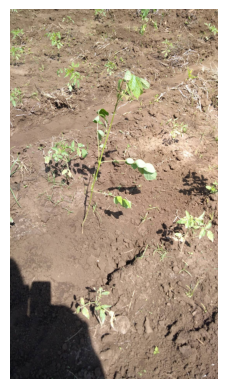

Confidence is 0.6919273599568858


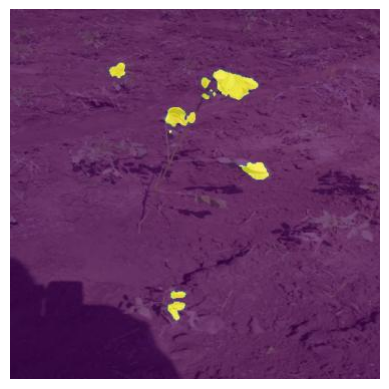

In [17]:
get_overlayed_mask(downstreamed_large, img_link)

In [ ]:
get_overlayed_mask(downstreamed_small, img_link)

Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth


Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth


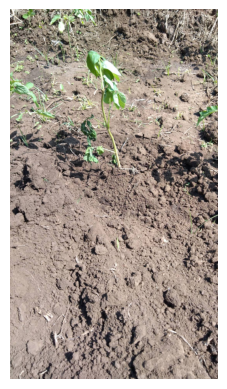

Confidence is 0.8375519254870006


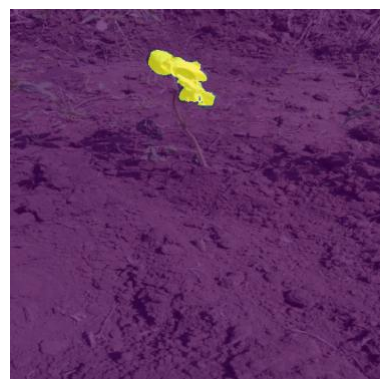

In [13]:
get_overlayed_mask(inhouse_default, img_link)

In [114]:
i = 3490

In [28]:
import random

def display_random(index):
    for i in range(index):
        r = random.randint(1,len(img_url_list))
        print('inhouse_default')
        get_overlayed_mask(inhouse_default,img_url_list[r])
        print('downstreamed_tuned')
        get_overlayed_mask(downstreamed_tuned,img_url_list[r] )

Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth


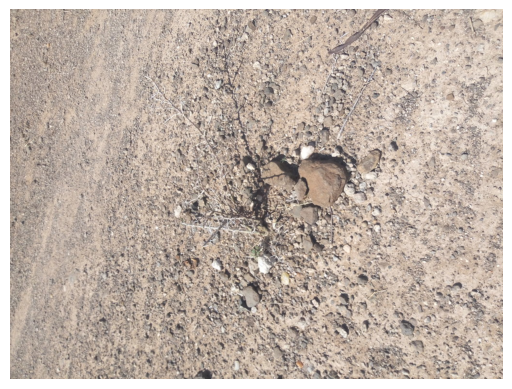

Confidence is 0.839785665994162


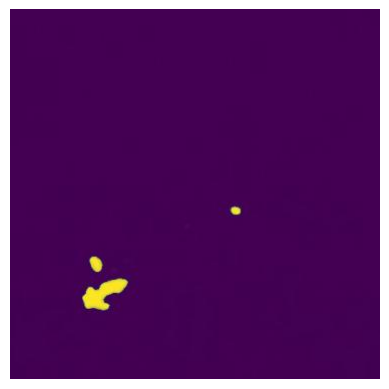

In [19]:
get_overlayed_mask(downstreamed_tuned, img_url_list[789])

In [26]:
import cv2
def filter_noise(img_path, min_component_size):
    binary_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    binary_mask = np.array(binary_image)
    binary_mask = np.where(binary_mask > 0, 1, 0)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask.astype(np.uint8), connectivity=4)
    
    # Filter components based on size
    filtered_mask = np.zeros_like(binary_mask)
    for label in range(1, num_labels):
        component_size = stats[label, cv2.CC_STAT_AREA]
        if component_size >= min_component_size:
            filtered_mask[labels == label] = 1
    binary_image = np.where(binary_mask > 0, 255, 0).astype(np.uint8)

    # Save binary image using OpenCV
    cv2.imwrite('check_processed.jpg', binary_image)




In [27]:
import cv2

# Read the input image
image = cv2.imread('/teamspace/studios/this_studio/Deeplab/check.jpg')

# Apply Gaussian blur to the image
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding
threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/thresh.cpp:1555: error: (-2:Unspecified error) in function 'double cv::threshold(cv::InputArray, cv::OutputArray, double, double, int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 16 (CV_8UC3)


In [13]:
import cv2

# Read the input image
image = cv2.imread('check.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply thresholding
threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


In [14]:

# Apply the Component analysis function 
analysis = cv2.connectedComponentsWithStats(threshold, 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 
  
# Initialize a new image to 
# store all the output components 
output = np.zeros((512, 512), dtype="uint8")

In [15]:
# Loop through each component 
for i in range(1, totalLabels): 
	area = values[i, cv2.CC_STAT_AREA] 
	print(area)

	if (area > 1000):
		
		# Labels stores all the IDs of the components on the each pixel 
		# It has the same dimension as the threshold 
		# So we'll check the component 
		# then convert it to 255 value to mark it white 
		componentMask = (label_ids == i).astype("uint8") * 255
		
		# Creating the Final output mask 
		output = cv2.bitwise_or(output, componentMask) 


223418


In [19]:
def polygon_vertices(mask):
    '''
    Find contours in the binary image

    mask: binary image to find contours in
    '''
    # Convert the image into 0 and 1 (background and foreground)
    _, binary_image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Extract segmentations
    segmentations = []
    for contour in contours:
        # Approximate contour to polygon
        if len(contour) < 3:
            continue

        contour = cv2.approxPolyDP(contour, 1, True)
        segmentation = contour.flatten().tolist()
        segmentations.append(segmentation)

    return segmentations

def calculate_polygon_area(vertices):
    # Ensure the polygon is closed (first and last vertices are the same)
    if vertices[0] != vertices[-2] or vertices[1] != vertices[-1]:
        vertices.extend(vertices[:2])

    # Calculate the area using the shoelace formula
    area = 0
    n = len(vertices) // 2
    for i in range(n - 1):
        area += (vertices[2*i] * vertices[2*i+3] - vertices[2*i+1] * vertices[2*i+2])
    area += (vertices[2*n-2] * vertices[1] - vertices[2*n-1] * vertices[0])
    return abs(area) / 2

def create_pair(t):
  pair = list(zip(t[::2],t[1::2]))
  new_pair = []
  for i in pair:
    new_pair.append(list(i))
  return new_pair

mask = cv2.imread('check.jpg', cv2.IMREAD_GRAYSCALE)
#print(find_contours(mask))


In [35]:
def calculate_polygon_area(vertices):
    # Ensure the polygon is closed (first and last vertices are the same)
    if vertices[0] != vertices[-2] or vertices[1] != vertices[-1]:
        vertices.extend(vertices[:2])

    # Calculate the area using the shoelace formula
    area = 0
    n = len(vertices) // 2
    for i in range(n - 1):
        area += (vertices[2*i] * vertices[2*i+3] - vertices[2*i+1] * vertices[2*i+2])
    area += (vertices[2*n-2] * vertices[1] - vertices[2*n-1] * vertices[0])
    return abs(area) / 2
mask = cv2.imread('check.jpg', cv2.IMREAD_GRAYSCALE)
# Assuming segmentation is a list of polygons in xyxy format
segmentation = polygon_vertices(mask)


# Iterate through the list segmentation and print the area of each polygon
for i, polygon in enumerate(segmentation):
    area = calculate_polygon_area(polygon)
    #print(f"Area of polygon {i+1}: {area}")


In [36]:
threshold = 100
poly_return = [polygon for polygon in segmentation if calculate_polygon_area(polygon) > threshold]
print(len(poly_return))
print(len(segmentation))

2
5


In [30]:
def create_pair(t):
  pair = list(zip(t[::2],t[1::2]))
  new_pair = []
  for i in pair:
    new_pair.append(list(i))
  return new_pair

In [31]:
print(create_pair(segmentation[0]))

[[63, 485], [69, 487], [71, 486], [69, 482], [66, 482], [63, 485]]


In [32]:
binary_mask = np.zeros((512, 512), dtype=np.uint8)
for i in poly_return:
  pair = create_pair(i)
  polygon_points = np.array(pair, np.int32)
  cv2.fillPoly(binary_mask, [polygon_points], 255)
cv2.imwrite('check_processed.jpg', binary_mask)

True

In [23]:
import cv2

# Read the binary image
binary_image = cv2.imread('check_processed.jpg', cv2.IMREAD_GRAYSCALE)

# Find coordinates of non-zero pixels (white pixels)
non_zero_coords = cv2.findNonZero(binary_image)

# Calculate bounding box
x, y, w, h = cv2.boundingRect(non_zero_coords)

# Display the bounding box
print("Bounding Box (x, y, width, height):", (x, y, w, h))


Bounding Box (x, y, width, height): (0, 0, 512, 472)


In [24]:
plt.imshow(output, cmap='gray')
plt.colorbar()  # Optional: Add a color bar to show the mapping between pixel values and colors
plt.show()

NameError: name 'plt' is not defined

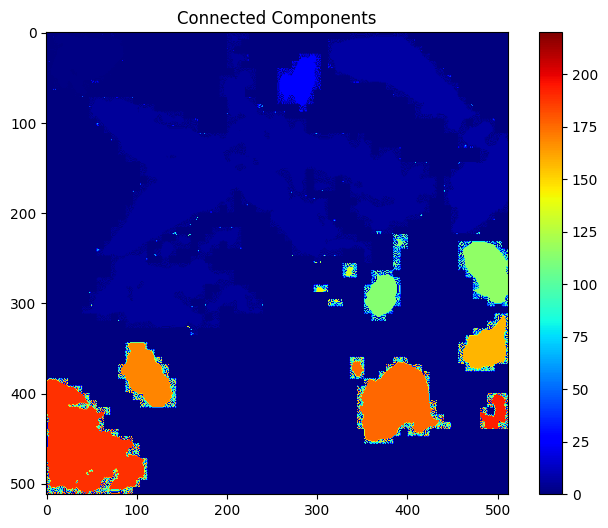

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

binary_image = cv2.imread('check.jpg', cv2.IMREAD_GRAYSCALE)
binary_mask = np.array(binary_image)
# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

# Visualize connected components
plt.figure(figsize=(8, 6))
plt.imshow(labels, cmap='jet')
plt.colorbar()
plt.title('Connected Components')
plt.show()


In [34]:

filter_noise('/teamspace/studios/this_studio/Deeplab/check.jpg', 100)

In [35]:
import pandas as pd

# Read the original CSV file into a DataFrame
df = pd.read_csv('/teamspace/studios/this_studio/india_deeplab_confidence_processed.csv')

# Randomly select 1000 rows from the DataFrame
random_df = df.sample(n=1000, random_state=42)

# Save the randomly selected rows to a new CSV file
random_df.to_csv('/teamspace/studios/this_studio/random_sampled_india_deeplab_confidence_processed.csv', index=False)


In [37]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/teamspace/studios/this_studio/india_deeplab_confidence_processed.csv')

# Rename the column
df.rename(columns={'Deeplab Confidence': 'Deeplab Confidence Inhouse Processed'}, inplace=True)

# Save the DataFrame to a new CSV file
df.to_csv('/teamspace/studios/this_studio/india_deeplab_confidence_processed.csv', index=False)
